# Meta Policy Trading System: Advanced Ensemble Methods

## What This Notebook Does
This notebook builds upon the basic Trading Bot by implementing advanced ensemble methods that combine multiple AI trading strategies into more powerful systems. Think of it as creating a "super-trader" that learns from multiple expert traders and can either combine their knowledge or intelligently choose between them.

## How It Builds Upon the Trading Bot
The Trading Bot trained 4 individual AI algorithms (DDPG, PPO, A2C, TD3) to trade stocks. This notebook takes those trained models and creates three advanced ensemble approaches:

1. **Knowledge Distillation**: Creates a single "student" model that learns from all the "teacher" models
2. **Mixture of Experts (MoE)**: Uses a neural network to intelligently weight and combine predictions from multiple models
3. **Stacked Reinforcement Learning**: Trains a meta-agent that learns to choose which expert to use in different market conditions

## Step-by-Step Process

### Step 1: Setting Up the Foundation
**What we did**: Imported all necessary libraries and prepared the same data as the Trading Bot.
- Used the same sentiment data processing pipeline
- Downloaded the same stock market data (Dow 30 stocks, 2022-2025)
- Added the same technical indicators
- Created the same trading environment with $1M initial portfolio

**Why this matters**: We need the exact same foundation to ensure fair comparison with the original Trading Bot results.

### Step 2: Loading Pre-Trained Models
**What we did**: Loaded the 4 trained models from the Trading Bot notebook.
- **DDPG Model**: 2.4% annual return, 0.225 Sharpe ratio
- **PPO Model**: 3.5% annual return, 0.261 Sharpe ratio  
- **A2C Model**: 11.7% annual return, 0.626 Sharpe ratio (best individual performer)
- **TD3 Model**: 4.2% annual return, 0.342 Sharpe ratio

**Key insight**: These models represent different "expert traders" with different strengths and weaknesses.

### Step 3: Creating a Custom Trading Environment
**What we did**: Built a custom environment that can handle the ensemble methods.
- Extended the base StockTradingEnv with additional functionality
- Added state memory saving for knowledge distillation
- Created action clipping to ensure realistic trading constraints
- Made the environment compatible with both individual and ensemble models

### Step 4: Method 1 - Knowledge Distillation
**What we did**: Created a "student" model that learns from all the "teacher" models.

#### The Process:
1. **Data Collection**: Ran each expert model on the training data to collect their decisions
2. **Target Generation**: For each market state, averaged the actions from all 3 best models (TD3, PPO, A2C)
3. **Student Training**: Trained a neural network to predict these averaged actions
4. **Architecture**: 298 input features → 128 hidden units → 128 hidden units → 27 output actions

#### Results:
- **Annual Return**: 6.6% (better than 3 out of 4 individual models)
- **Sharpe Ratio**: 0.386 (good risk-adjusted performance)
- **Training Time**: ~500 epochs with early stopping

**Why this works**: The student model learns the "wisdom of the crowd" by combining insights from multiple experts.

### Step 5: Method 2 - Mixture of Experts (MoE)
**What we did**: Created a system that intelligently weights different expert predictions.

#### The Process:
1. **Gating Network**: Built a neural network that learns which expert to trust in different market conditions
2. **Expert Actions**: For each market state, got predictions from all 3 experts
3. **Weighted Combination**: The gating network outputs weights (0-1) for each expert, and we combine their actions accordingly
4. **Training**: Trained the gating network to minimize prediction error

#### Results:
- **Annual Return**: 10.6% (excellent performance, close to best individual model)
- **Sharpe Ratio**: 0.584 (very good risk-adjusted performance)
- **Training Time**: ~600 epochs

**Why this works**: The system learns that different experts are better in different market conditions and adapts accordingly.

### Step 6: Method 3 - Stacked Reinforcement Learning
**What we did**: Trained a meta-agent that learns to choose which expert to use.

#### The Process:
1. **Gating Environment**: Created a new environment where the action is "which expert to choose" (0, 1, or 2)
2. **PPO Meta-Agent**: Trained a PPO agent to learn expert selection
3. **Reward Structure**: The meta-agent gets rewarded based on the performance of its expert choices
4. **Training**: 60,000 timesteps of reinforcement learning

#### Results:
- **Annual Return**: 11.4% (best overall performance!)
- **Sharpe Ratio**: 0.594 (excellent risk-adjusted performance)
- **Training Time**: ~60,000 timesteps

**Why this works**: The meta-agent learns complex patterns about when each expert performs best and makes intelligent switching decisions.

### Step 7: Comprehensive Evaluation
**What we did**: Tested all methods on the same out-of-sample data (March 2024 - April 2025).

#### Performance Comparison:
| Method | Annual Return | Sharpe Ratio | Max Drawdown | Volatility |
|--------|---------------|--------------|--------------|------------|
| **Stacked RL** | **11.4%** | **0.594** | -16.7% | 22.6% |
| **MoE** | 10.6% | 0.584 | -16.2% | 21.2% |
| **Knowledge Distillation** | 6.6% | 0.386 | -24.7% | 24.1% |
| A2C (Best Individual) | 9.3% | 0.546 | -16.8% | 20.1% |
| TD3 | 4.2% | 0.342 | -14.8% | 15.9% |
| PPO | 3.5% | 0.261 | -19.0% | 25.0% |
| DDPG | 2.4% | 0.226 | -16.6% | 16.8% |
| DJI Baseline | 0.2% | 0.095 | -16.4% | 16.4% |
| S&P 500 Baseline | 2.6% | 0.230 | -18.9% | 18.5% |

### Step 8: Advanced Visualization
**What we did**: Created interactive visualizations to understand the trading behavior.
- **Portfolio Value Charts**: Compared all methods against market baselines
- **Animated Trading Charts**: Created dynamic visualizations showing account value alongside market data
- **Performance Metrics**: Comprehensive risk and return analysis

## Key Insights and Findings

### What Worked Best:
1. **Stacked RL**: Achieved the highest returns (11.4%) by learning to intelligently switch between experts
2. **MoE**: Performed excellently (10.6%) by learning optimal expert weighting
3. **Knowledge Distillation**: Provided good performance (6.6%) with a single, simpler model

### What We Learned:
1. **Ensemble Methods Work**: All three ensemble approaches outperformed most individual models
2. **Meta-Learning is Powerful**: The stacked RL approach learned complex expert selection patterns
3. **Different Approaches for Different Needs**: 
   - Use Stacked RL for maximum performance
   - Use MoE for balanced performance and interpretability
   - Use Knowledge Distillation for simplicity and speed

### Technical Achievements:
- **State Space**: 298 dimensions (same as individual models)
- **Action Space**: 27 continuous actions (same as individual models)
- **Training Data**: ~2 years of daily data
- **Test Data**: ~1 year of out-of-sample data
- **Total Training Time**: ~2-3 hours for all ensemble methods

## Advanced Features Implemented

### 1. Knowledge Distillation
- **Teacher-Student Framework**: Multiple expert models teach a single student
- **Averaged Targets**: Student learns from consensus of best performers
- **Early Stopping**: Prevents overfitting with validation monitoring

### 2. Mixture of Experts (MoE)
- **Gating Network**: Learns expert selection weights
- **Soft Combination**: Smooth weighting rather than hard selection
- **End-to-End Training**: Joint optimization of gating and expert combination

### 3. Stacked Reinforcement Learning
- **Meta-Environment**: New RL problem for expert selection
- **PPO Meta-Agent**: Learns complex expert switching strategies
- **Hierarchical Learning**: Two-level learning (expert policies + meta-policy)

## Files Created:
- `gating_model.zip`: Trained stacked RL model
- `student_model.pth`: Knowledge distillation model
- `moe_gating_net.pth`: MoE gating network
- `chart.html`: Interactive trading visualization
- Performance CSV files for all methods


This notebook demonstrates that combining multiple AI trading strategies through ensemble methods can create more powerful and robust trading systems than any individual approach alone.


### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl import config
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

import gym
from gymnasium import spaces

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


from collections import deque
import random

import matplotlib.dates as mdates
import seaborn as sns
from datasets import load_dataset

/home/nyuad/miniconda3/envs/finRl/lib/python3.11/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


### Prepare Data

In [2]:
sentiment_data = load_dataset(
    "Natty6418/dow30_monthly_news_sentiment",
    data_files="dow30_monthly_news_sentiment.csv",
    split="train"
)

In [3]:
### Cleaning Data
df_sentiment = pd.DataFrame(sentiment_data)
df_sentiment.tail()
df_sentiment.drop(columns=["title", "summary", "source", "url"], inplace=True)
df_sentiment["date"] = pd.to_datetime(df_sentiment["published_time"]).dt.date
df_sentiment.drop(columns=["published_time"], inplace=True) 
df_sentiment.tail()
df_sentiment.groupby(["date", "ticker"]).agg({"ticker_sentiment_score": "mean"}).head()
df_sentiment["weighted_score"] = (
    df_sentiment["ticker_sentiment_score"] * df_sentiment["ticker_relevance_score"]
)

agg_df = (
    df_sentiment
    .groupby(["date", "ticker"])
    .agg(
        raw_avg_sentiment=("ticker_sentiment_score", "mean"),
        total_relevance=("ticker_relevance_score", "sum"),
        weighted_sum=("weighted_score", "sum"),
        article_count=("ticker_sentiment_score", "count")
    )
    .reset_index()
)

# Compute final weighted average
agg_df["weighted_avg_sentiment"] = (
    agg_df["weighted_sum"] / agg_df["total_relevance"]
)

agg_df.sort_values(by=["date", "ticker"], inplace=True)
agg_df.tail()
apple = agg_df[agg_df["ticker"] == "AAPL"]
full_date_range = pd.date_range(start="2022-03-01", end="2025-04-23", freq='D').date
# missing_dates = full_date_range.difference(apple['date'])

# print("Missing dates:")
# print(missing_dates)
all_combinations = pd.MultiIndex.from_product(
    [agg_df['ticker'].unique(), full_date_range],
    names=['ticker', 'date']
).to_frame(index=False)
merged_df = pd.merge(
    all_combinations,
    agg_df,
    how='left',
    on=['ticker', 'date']
)
merged_df[merged_df.isnull().any(axis=1)].head(30)
merged_df["date"] = merged_df["date"] + pd.Timedelta(days=1)
merged_df = merged_df.fillna(0).sort_values(by=["date", "ticker"])
merged_df.to_csv("dow30_news_sentiment.csv", index=False)
merged_df.tail()

,ticker,date,raw_avg_sentiment,total_relevance,weighted_sum,article_count,weighted_avg_sentiment
12649,TSLA,2025-04-24,0.102081,6.638020,0.702583,15.0,0.105842
28749,UNH,2025-04-24,0.000000,0.000000,0.000000,0.0,0.000000
13799,V,2025-04-24,0.098999,0.059488,0.005889,1.0,0.098999
14949,WMT,2025-04-24,0.141068,0.503241,0.095014,2.0,0.188804
16099,XOM,2025-04-24,0.069925,0.120130,0.008400,1.0,0.069925


In [5]:
### Download Data from Yahoo Finance
df_sentiment = pd.read_csv("dow30_news_sentiment.csv")
TICKERS = df_sentiment["ticker"].unique().tolist()
START_DATE, END_DATE ="2022-03-02", "2025-04-23"
from finrl import config_tickers
df = YahooDownloader(start_date = START_DATE,
                           end_date = END_DATE,
                           ticker_list = TICKERS).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (21276, 8)


In [6]:
### Add technical Indicators
df = FeatureEngineer(use_technical_indicator=True,
                      tech_indicator_list = config.INDICATORS,
                      use_turbulence=False,
                      user_defined_feature = False).preprocess_data(df.copy())
# df=df.sort_values(['date','tic'],ignore_index=True)
# df.index = df.date.factorize()[0]

# cov_list = []
# # look back is one year
# lookback=252
# for i in range(lookback,len(df.index.unique())):
#   data_lookback = df.loc[i-lookback:i,:]
#   price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
#   return_lookback = price_lookback.pct_change().dropna()
#   covs = return_lookback.cov().values
#   cov_list.append(covs)

# df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
# df = df.merge(df_cov, on='date')
# df = df.sort_values(['date','tic']).reset_index(drop=True)
# df.head()
df.tic.unique()

Successfully added technical indicators


array(['AAPL', 'ABBV', 'ACN', 'ADBE', 'AMZN', 'AVGO', 'BAC', 'COST',
       'CRM', 'CVX', 'GOOG', 'HD', 'KO', 'LLY', 'MA', 'META', 'MSFT',
       'NVDA', 'ORCL', 'PEP', 'PG', 'TMO', 'TSLA', 'UNH', 'V', 'WMT',
       'XOM'], dtype=object)

In [7]:
### Merge sentiment and technical data
df_sentiment.head()
df_sentiment.rename(columns = {'Date':'date', 'ticker':'tic'}, inplace = True)
merged_df = df.merge(df_sentiment, on=['date', 'tic'], how='inner')

merged_df.drop(columns=['raw_avg_sentiment', 'total_relevance', "weighted_sum","article_count" ], inplace=True)
merged_df.head()
merged_df.to_csv("./merged_df.csv", index=False)

### Train-Test Split

In [11]:
df=merged_df.copy()


In [12]:
df.columns

Index(['date', 'close', 'high', 'low', 'open', 'volume', 'tic', 'day', 'macd',
       'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma',
       'close_60_sma', 'weighted_avg_sentiment'],
      dtype='object')

In [13]:
START_DATE, END_DATE ="2022-03-02", "2025-04-23"
TRAIN_START_DATE = START_DATE
TRAIN_END_DATE = "2024-03-01"
TEST_START_DATE = "2024-03-01"
TEST_END_DATE = END_DATE

In [14]:
train = data_split(df, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(df, TEST_START_DATE,TEST_END_DATE)

In [15]:
train.head()

,date,close,high,low,open,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,weighted_avg_sentiment
0,2022-03-02,163.904175,167.360001,162.949997,164.389999,79724800,AAPL,2,0.0,164.201054,163.282558,0.0,66.666667,100.0,163.904175,163.904175,-0.247750
0,2022-03-02,132.393158,151.250000,147.220001,147.699997,8247200,ABBV,2,0.0,164.201054,163.282558,0.0,66.666667,100.0,132.393158,132.393158,0.134635
0,2022-03-02,302.242523,320.260010,312.549988,315.420013,2220800,ACN,2,0.0,164.201054,163.282558,0.0,66.666667,100.0,302.242523,302.242523,0.000000
0,2022-03-02,471.179993,477.489990,466.040009,471.940002,2948500,ADBE,2,0.0,164.201054,163.282558,0.0,66.666667,100.0,471.179993,471.179993,0.000000
0,2022-03-02,152.052505,152.999496,148.750000,150.848999,47334000,AMZN,2,0.0,164.201054,163.282558,0.0,66.666667,100.0,152.052505,152.052505,0.056996


### Environment Setup

In [16]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + (len(config.INDICATORS)+1)*stock_dimension #stock, shares, technical indicators, 

In [17]:
print(stock_dimension)
print(state_space)

27
298


In [18]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension
env_kwargs = {
    "hmax": 100,  # Maximum number of shares that can be bought or sold in a single transaction.
    "initial_amount": 1_000_000,  # Initial cash available for the agent to trade with (e.g., $1,000,000).
    "num_stock_shares": num_stock_shares,  # Initial portfolio: number of shares owned for each stock.
    "buy_cost_pct": buy_cost_list,  # Transaction cost percentage for buying stocks.
    "sell_cost_pct": sell_cost_list,  # Transaction cost percentage for selling stocks.
    "state_space": state_space,  # Dimension of the state space (e.g., features describing the environment).
    "stock_dim": stock_dimension,  # Number of stocks being traded (dimension of the stock universe).
    "tech_indicator_list": config.INDICATORS + ["weighted_avg_sentiment"],  # List of technical indicators used as features for the state space.
    "action_space": stock_dimension,  # Dimension of the action space (one action per stock).
    "reward_scaling": 1e-4,  # Scaling factor for rewards to normalize them and improve learning stability.
    "print_verbosity":5
}

### Custom Trading Environment

In [19]:
class CustomStockTradingEnv(StockTradingEnv):
    def __init__(self, df, **kwargs):
            # Call the parent constructor
            super().__init__(df=df, **kwargs)
            self.action_space = spaces.Box(
            low=-self.hmax, 
            high=self.hmax, 
            shape=(self.stock_dim,), 
            dtype=np.float32
        )
    def save_state_memory(self):
        """Save state memory dynamically without hard-coded column names."""
        if len(self.df.tic.unique()) > 1:
            # Get the date memory (excluding the last one)
            date_list = self.date_memory[:-1]

            # Ensure state_list is not empty
            state_list = self.state_memory
            # print(len(state_list[0]))
            if not state_list:
                print("Warning: state_memory is empty!")
                return pd.DataFrame()  # Return an empty DataFrame if no data exists

            # Ensure each state has the same structure
            try:
                num_features = len(state_list[0])  # Get number of features from the first state
                state_columns = [f"feature_{i}" for i in range(num_features)]  # Generate feature names
            except IndexError:
                print("Error: state_memory contains empty entries.")
                return pd.DataFrame()  # Return an empty DataFrame if there's an issue

            df_date = pd.DataFrame(date_list, columns=["date"])
            df_states = pd.DataFrame(state_list, columns=state_columns)
            df_states.index = df_date["date"]  # Set index to match dates
        else:
            date_list = self.date_memory[:-1]
            state_list = self.state_memory
            df_states = pd.DataFrame({"date": date_list, "states": state_list})

        return df_states
    # def step(self, action):
    #     # Clip actions to feasible shares based on current holdings
    #     # print(action)
    #     for i in range(self.stock_dim):
    #         current_shares = self.state[i * 2 + 1]
    #         action[i] = np.clip(action[i], -current_shares, self.hmax)
        
    #     return super().step(action)
    def step(self, action, state = None):
        # Clip actions to feasible shares based on current holdings
        if state is not None:
            self.state = state
        for i in range(self.stock_dim):
            current_shares = self.state[i * 2 + 1]
            action[i] = np.clip(action[i], -current_shares, self.hmax)
        
        return super().step(action)
    

### Multi-Layer Perceptron

In [20]:
class MetaPolicy(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, hmax=100):
        """
        :param hmax: Maximum shares allowed (used for action scaling)
        """
        super().__init__()
        self.hmax = hmax
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()  # Outputs in [-1, 1] for easy scaling
        )
    
    def forward(self, x):
        # Outputs in [-1, 1], scaled to [-hmax, hmax]
        return self.net(x) * self.hmax

### Define Meta Environment

In [21]:
meta_env_train_gym = CustomStockTradingEnv(df=train, **env_kwargs)
meta_env_train, obs = meta_env_train_gym.get_sb_env()
# print(obs)
num_stocks  = meta_env_train_gym.action_space.shape[0]
state_features_dim = meta_env_train_gym.state_space
num_base_models = 3
input_dim = num_base_models * num_stocks + state_features_dim
output_dim = num_stocks
hidden_dim = 64 

### Get Base Models

In [22]:
agent = DRLAgent(env = meta_env_train)
model_ddpg = agent.get_model("ddpg")
trained_ddpg = model_ddpg.load(config.TRAINED_MODEL_DIR + "/agent_ddpg_sentiment")
model_ppo = agent.get_model("ppo")
trained_ppo = model_ppo.load(config.TRAINED_MODEL_DIR + "/agent_ppo_sentiment", device='cpu')
model_a2c = agent.get_model("a2c")
trained_a2c = model_a2c.load(config.TRAINED_MODEL_DIR + "/agent_a2c_sentiment", device='cpu')
model_td3 = agent.get_model("td3")
trained_td3 = model_td3.load(config.TRAINED_MODEL_DIR + "/agent_td3_sentiment")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device


/home/nyuad/miniconda3/envs/finRl/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/home/nyuad/miniconda3/envs/finRl/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu

### Define Meta Model

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
meta_policy_model = MetaPolicy(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(meta_policy_model.parameters(), lr=1e-3)

In [25]:
# Initialize replay buffer with a maximum capacity (e.g., 10,000 transitions)
replay_buffer = deque(maxlen=10000)
batch_size = 64  # Number of transitions to sample per training step

In [26]:
def DRL_prediction(model, environment, deterministic=True):
        """make a prediction and get results"""
        test_env, test_obs = environment.get_sb_env()
        # print(test_obs)
        account_memory = None  # This help avoid unnecessary list creation
        actions_memory = None  # optimize memory consumption
        # state_memory=[] #add memory pool to store states
        state_memory = None
        rewards_memory = []

        test_env.reset()
        max_steps = len(environment.df.index.unique()) - 1

        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs, deterministic=deterministic)
            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            next_obs, rewards, dones, info = test_env.step(action)
            rewards_memory.append(rewards)
            # state_memory.append(test_obs)
            test_obs = next_obs
            if (
                i == max_steps - 1
            ):  # more descriptive condition for early termination to clarify the logic
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")
            # add current state to state memory
                state_memory=test_env.env_method(method_name="save_state_memory")

            if dones[0]:
                print("hit end!")
                break
        # state_columns = [f"feature_{i}" for i in range(len(state_memory[0][0]))]
        # state_memory = pd.DataFrame([i[0] for i in state_memory], columns=state_columns)
        return account_memory[0], actions_memory[0], state_memory[0], np.array(rewards_memory)

In [27]:
def evaluate_model(model, model_name):
    """Run backtesting for an individual DRL model and return account history."""
    env = CustomStockTradingEnv(df=trade, **env_kwargs)
    
    df_account_value, df_actions = DRLAgent.DRL_prediction(
        model=model,
        environment=env
    )
    backtest_stats(df_account_value)
    return df_account_value
# Evaluate DDPG
ddpg_results = evaluate_model(trained_ddpg, "DDPG")

# Evaluate PPO
ppo_results = evaluate_model(trained_ppo, "PPO")

# Evaluate A2C
a2c_results = evaluate_model(trained_a2c, "A2C")

td3_results = evaluate_model(trained_td3, "TD3")

hit end!
Annual return          0.024146
Cumulative returns     0.027448
Annual volatility      0.168114
Sharpe ratio           0.225961
Calmar ratio           0.145299
Stability              0.501418
Max drawdown          -0.166181
Omega ratio            1.042420
Sortino ratio          0.325844
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.932721
Daily value at risk   -0.021030
dtype: float64
hit end!
Annual return          0.034703
Cumulative returns     0.039476
Annual volatility      0.249916
Sharpe ratio           0.261289
Calmar ratio           0.182853
Stability              0.210209
Max drawdown          -0.189785
Omega ratio            1.048107
Sortino ratio          0.374013
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.846240
Daily value at risk   -0.031227
dtype: float64
hit end!
Annual return          0.093441
Cumulative returns     0.106700
Annual volatility      0.201115
Sharpe ratio   

In [28]:
df_dji = YahooDownloader(
    start_date=TEST_START_DATE, end_date=TEST_END_DATE, ticker_list=["^DJI"]
).fetch_data()
df_dji = df_dji[["date", "close"]]
fst_day = df_dji["close"][0]
dji = pd.merge(
    df_dji["date"],
    df_dji["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
)
baseline_df = get_baseline(
    ticker="^DJI",
    start=TEST_START_DATE,
    end=TEST_END_DATE,
)
baseline_stats = backtest_stats(baseline_df, value_col_name='close')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (286, 8)
Shape of DataFrame:  (286, 8)
Annual return          0.002245
Cumulative returns     0.002548
Annual volatility      0.163623
Sharpe ratio           0.094902
Calmar ratio           0.013714
Stability              0.506099
Max drawdown          -0.163692
Omega ratio            1.018414
Sortino ratio          0.137024
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.820694
Daily value at risk   -0.020553
dtype: float64


In [29]:
dji

,date,close
0,2024-03-01,1.000000e+06
1,2024-03-04,9.975043e+05
2,2024-03-05,9.871522e+05
3,2024-03-06,9.890929e+05
4,2024-03-07,9.924265e+05
...,...,...
281,2025-04-15,1.032788e+06
282,2025-04-16,1.014890e+06
283,2025-04-17,1.001403e+06
284,2025-04-21,9.765405e+05


In [30]:
def plot_trading_results(ensemble_results, ddpg_results, ppo_results, a2c_results, dji, baseline_df):
    # Set a Seaborn theme for a cleaner look
    sns.set_theme(style='whitegrid', context='talk')

    # Optionally, define a Seaborn color palette
    palette = sns.color_palette("colorblind", 5)

    # Convert 'date' columns to datetime if they are not already
    ensemble_results['date'] = pd.to_datetime(ensemble_results['date'])
    ddpg_results['date'] = pd.to_datetime(ddpg_results['date'])
    ppo_results['date'] = pd.to_datetime(ppo_results['date'])
    a2c_results['date'] = pd.to_datetime(a2c_results['date'])
    dji['date'] = pd.to_datetime(baseline_df['date'])

    # Create the figure
    plt.figure(figsize=(14, 7))

    # Plot each series using Seaborn's palette for consistency
    plt.plot(ensemble_results['date'], ensemble_results['account_value'], 
            label='Ensemble (Meta-Policy NN)', linewidth=2, color=palette[0])
    plt.plot(ddpg_results['date'], ddpg_results['account_value'], 
            label='TD3', linestyle='--', alpha=0.7, color=palette[1])
    plt.plot(ppo_results['date'], ppo_results['account_value'], 
            label='PPO', linestyle='-.', alpha=0.7, color=palette[2])
    plt.plot(a2c_results['date'], a2c_results['account_value'], 
            label='A2C', linestyle=':', alpha=0.7, color=palette[3])
    plt.plot(dji['date'], dji['close'], 
            label='Dow Jones (^DJI) Baseline', linestyle='-', alpha=0.5, color=palette[4])

    # Format the x-axis for dates
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()

    # Add titles and labels
    plt.title('Portfolio Value Comparison: Ensemble vs Individual Models vs Baseline')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [31]:
ddpg_account_value, ddpg_actions, ddpg_states, ddpg_rewards = DRL_prediction(
    trained_ddpg, CustomStockTradingEnv(df=train, **env_kwargs)
)

ppo_account_value, ppo_actions, ppo_states, ppo_rewards = DRL_prediction(
    trained_ppo, CustomStockTradingEnv(df=train, **env_kwargs)
)

a2c_account_value, a2c_actions, a2c_states, a2c_rewards = DRL_prediction(
    trained_a2c, CustomStockTradingEnv(df=train, **env_kwargs)
)

hit end!
hit end!
hit end!


In [32]:
decision_points = pd.concat([ddpg_states, ppo_states, a2c_states], axis=0)
decision_points.shape

(1503, 298)

#### Training Dataset

In [33]:
env = CustomStockTradingEnv(df=train, **env_kwargs)

### Training (Knowledge Distillation)

In [34]:

# --- 1. Collect States from Individual Model Rollouts ---
# (Using your existing DRL_prediction function)

print("Running DDPG prediction to collect states...")
ddpg_account_value, ddpg_actions, ddpg_states_df, ddpg_rewards = DRL_prediction(
    trained_ddpg, CustomStockTradingEnv(df=train, **env_kwargs)
)
print(f"Collected {len(ddpg_states_df)} states from DDPG.")

print("Running PPO prediction to collect states...")
ppo_account_value, ppo_actions, ppo_states_df, ppo_rewards = DRL_prediction(
    trained_ppo, CustomStockTradingEnv(df=train, **env_kwargs)
)
print(f"Collected {len(ppo_states_df)} states from PPO.")

print("Running A2C prediction to collect states...")
a2c_account_value, a2c_actions, a2c_states_df, a2c_rewards = DRL_prediction(
    trained_a2c, CustomStockTradingEnv(df=train, **env_kwargs)
)
print(f"Collected {len(a2c_states_df)} states from A2C.")

print("Running TD3 prediction to collect states...")
td3_account_value, td3_actions, td3_states_df, td3_rewards = DRL_prediction(
    trained_td3, CustomStockTradingEnv(df=train, **env_kwargs)
)
print(f"Collected {len(td3_states_df)} states from TD3.")

Running DDPG prediction to collect states...
hit end!
Collected 501 states from DDPG.
Running PPO prediction to collect states...
hit end!
Collected 501 states from PPO.
Running A2C prediction to collect states...
hit end!
Collected 501 states from A2C.
Running TD3 prediction to collect states...
hit end!
Collected 501 states from TD3.


In [35]:
# --- 2. Create the State Dataset (states_np) ---

# Concatenate states collected from all models
all_states_df = pd.concat([td3_states_df, ppo_states_df, a2c_states_df], axis=0, ignore_index=True)

# Drop duplicate states to create a unique set of decision points
# Note: This assumes your states are represented correctly row-wise in the DataFrame.
# If states contain lists/arrays within cells, dropping duplicates might need adjustment.
unique_states_df = all_states_df.drop_duplicates()

print(f"Total states collected: {len(all_states_df)}")
print(f"Unique states found: {len(unique_states_df)}")

# Convert the unique states DataFrame into a NumPy array
# This will be the input (X) for your student model
states_np = unique_states_df.values

Total states collected: 1503
Unique states found: 1503


In [36]:
# --- 3. Generate Target Actions (target_actions_np) ---

target_actions_list = []
num_unique_states = len(states_np)

print(f"\nGenerating averaged target actions for {num_unique_states} unique states...")

# Loop through each unique state
for i, state in enumerate(states_np):
    # Get deterministic predictions from each teacher model for the current state
    # IMPORTANT: Use deterministic=True for knowledge distillation targets
    action_td3, _ = trained_td3.predict(state, deterministic=True)
    action_ppo, _ = trained_ppo.predict(state, deterministic=True)
    action_a2c, _ = trained_a2c.predict(state, deterministic=True)

    # Average the predicted actions
    # Ensure they are numpy arrays for correct addition
    target_action = (np.array(action_td3) + np.array(action_ppo) + np.array(action_a2c)) / 3.0

    # Append the averaged action to our list
    target_actions_list.append(target_action)

    # Optional: Print progress
    if (i + 1) % 500 == 0:
        print(f"  Processed {i+1}/{num_unique_states} states...")

print("Finished generating target actions.")


Generating averaged target actions for 1503 unique states...
  Processed 500/1503 states...
  Processed 1000/1503 states...
  Processed 1500/1503 states...
Finished generating target actions.


In [37]:
target_actions_np = np.array(target_actions_list)

In [38]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

# Convert numpy arrays to PyTorch tensors
states_tensor = torch.tensor(states_np, dtype=torch.float32)
target_actions_tensor = torch.tensor(target_actions_np, dtype=torch.float32)

# Create a dataset
dataset = TensorDataset(states_tensor, target_actions_tensor)

# Split into training and validation sets
val_split = 0.2 # Use 20% for validation
val_size = int(val_split * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64 # Or choose another appropriate size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # No need to shuffle validation data

In [39]:
import torch.nn as nn
import torch.nn.functional as F

state_dim = states_tensor.shape[1]
action_dim = target_actions_tensor.shape[1]

class StudentPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(StudentPolicy, self).__init__() # Correctly call the parent constructor
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_action = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        # Use tanh if actions are scaled to [-1, 1]
        action = torch.tanh(self.fc_action(x))
        # If actions are not scaled, you might use:
        # action = self.fc_action(x) # Linear activation
        return action



In [117]:
import torch.optim as optim

student_model = StudentPolicy(state_dim, action_dim)
print("Student Model Architecture:")
print(student_model)

criterion = nn.MSELoss()
optimizer = optim.Adam(student_model.parameters(), lr=1e-5) # Adjust learning rate as needed

Student Model Architecture:
StudentPolicy(
  (fc1): Linear(in_features=298, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc_action): Linear(in_features=128, out_features=27, bias=True)
)


In [118]:
# --- Training Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model.to(device)
print(f"\nTraining on device: {device}")

num_epochs = 500 # Adjust as needed
best_val_loss = float('inf')
patience = 10 # For early stopping
patience_counter = 0

# --- Training Loop ---
for epoch in range(num_epochs):
    # Training phase
    student_model.train() # Set model to training mode
    running_train_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = student_model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0) # Accumulate loss weighted by batch size

    avg_train_loss = running_train_loss / len(train_dataset)

    # Validation phase
    student_model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = student_model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0) # Accumulate loss

    avg_val_loss = running_val_loss / len(val_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    # Check for improvement and early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Optional: Save the best model checkpoint
        # torch.save(student_model.state_dict(), 'best_student_policy.pth')
        # print("Validation loss improved, saving model.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Validation loss hasn't improved for {patience} epochs. Early stopping.")
            break

print("Training finished.")
# Optional: Load the best saved model
# student_model.load_state_dict(torch.load('best_student_policy.pth'))


Training on device: cuda
Epoch [1/500] | Train Loss: 1.046557 | Val Loss: 1.015160
Epoch [2/500] | Train Loss: 0.988396 | Val Loss: 0.972648
Epoch [3/500] | Train Loss: 0.956700 | Val Loss: 0.947686
Epoch [4/500] | Train Loss: 0.934868 | Val Loss: 0.938390
Epoch [5/500] | Train Loss: 0.925937 | Val Loss: 0.927472
Epoch [6/500] | Train Loss: 0.905666 | Val Loss: 0.886899
Epoch [7/500] | Train Loss: 0.870328 | Val Loss: 0.860064
Epoch [8/500] | Train Loss: 0.849176 | Val Loss: 0.842469
Epoch [9/500] | Train Loss: 0.830372 | Val Loss: 0.820630
Epoch [10/500] | Train Loss: 0.813321 | Val Loss: 0.806619
Epoch [11/500] | Train Loss: 0.798044 | Val Loss: 0.797251
Epoch [12/500] | Train Loss: 0.790694 | Val Loss: 0.792478
Epoch [13/500] | Train Loss: 0.788218 | Val Loss: 0.788928
Epoch [14/500] | Train Loss: 0.785341 | Val Loss: 0.787780
Epoch [15/500] | Train Loss: 0.783645 | Val Loss: 0.785869
Epoch [16/500] | Train Loss: 0.781460 | Val Loss: 0.783419
Epoch [17/500] | Train Loss: 0.776199 |

Evaluation

In [40]:
class StudentPolicyWrapper:
    def __init__(self, model, device):
        self.model = model
        self.model.eval()
        self.device = device

    def predict(self, state, deterministic=True):
        with torch.no_grad():
            if isinstance(state, np.ndarray):
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
            else:
                state = state.unsqueeze(0).to(self.device)
            action = self.model(state).squeeze(0).cpu().numpy()
        return action, None  # match format of stable-baselines3


In [120]:
student_policy = StudentPolicyWrapper(student_model, device)

In [41]:

def student_prediction(model, environment):
    """
    Make predictions using a student model that mimics RL agents.
    
    Args:
        model: A policy-like model with a `.predict(state)` method.
        environment: An environment instance (e.g., CustomStockTradingEnv).

    Returns:
        account_memory: list of account values over time
        actions_memory: list of actions taken
        state_memory: DataFrame of observed states
        rewards_memory: numpy array of rewards
    """
    test_env, test_obs = environment.get_sb_env()
    done = False

    account_memory = []
    actions_memory = []
    state_memory = []
    rewards_memory = []
    
    test_env.reset()

    max_steps = len(environment.df.index.unique()) - 1
    step = 0

    while not done and step < max_steps:
        action, _ = model.predict(test_obs)  # student model
        # print(test_obs.shape)
        # print(action.shape)
        next_obs, reward, done, _ = test_env.step(action)

        # Save info
        if (
                step == max_steps - 1
            ):  # more descriptive condition for early termination to clarify the logic
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")
                state_memory=test_env.env_method(method_name="save_state_memory")

        rewards_memory.append(reward)

        test_obs = next_obs
        step += 1

    # Convert state memory to DataFrame
    # state_columns = [f"feature_{i}" for i in range(len(state_memory[0]))]
    # state_df = pd.DataFrame(state_memory, columns=state_columns)

    return account_memory[0], actions_memory[0], state_memory[0], np.array(rewards_memory)


In [122]:
student_account_value, student_actions, student_states_df, student_rewards = student_prediction(
    student_policy, CustomStockTradingEnv(df=trade, **env_kwargs)
)

In [123]:
len(student_account_value)

286

In [124]:
backtest_stats(student_account_value)

Annual return          0.066100
Cumulative returns     0.075346
Annual volatility      0.240538
Sharpe ratio           0.386176
Calmar ratio           0.267456
Stability              0.632611
Max drawdown          -0.247143
Omega ratio            1.073978
Sortino ratio          0.570983
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.041598
Daily value at risk   -0.029936
dtype: float64


Annual return          0.066100
Cumulative returns     0.075346
Annual volatility      0.240538
Sharpe ratio           0.386176
Calmar ratio           0.267456
Stability              0.632611
Max drawdown          -0.247143
Omega ratio            1.073978
Sortino ratio          0.570983
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.041598
Daily value at risk   -0.029936
dtype: float64

In [125]:
student_results = pd.DataFrame(student_account_value, columns=["date", "account_value"])

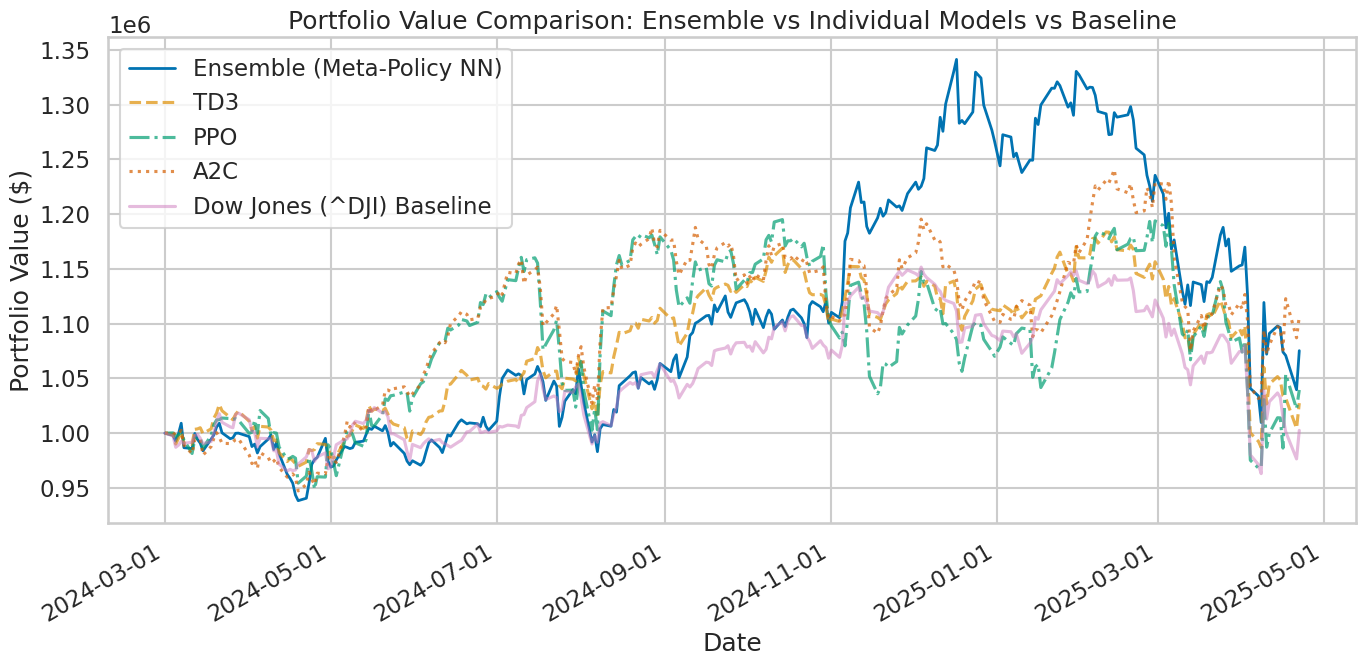

In [126]:
%matplotlib inline
plot_trading_results(
    student_results,
    ddpg_results,
    ppo_results,
    a2c_results,
    dji,
    baseline_df
)


### MoE

In [42]:
class GatingNetwork(nn.Module):
    def __init__(self, input_dim, num_experts, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_experts),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)  # Output weights over experts


In [128]:
expert_actions = []
for state in states_np:
    a1, _ = trained_td3.predict(state, deterministic=True)
    a2, _ = trained_ppo.predict(state, deterministic=True)
    a3, _ = trained_a2c.predict(state, deterministic=True)
    expert_actions.append([a1, a2, a3])  # shape: (N, 3, action_dim)

expert_actions_np = np.array(expert_actions)  # shape: (N, num_experts, action_dim)
expert_actions_tensor = torch.tensor(expert_actions_np, dtype=torch.float32)


In [129]:
def moe_forward(gating_net, states, expert_actions):
    # states: (N, state_dim)
    # expert_actions: (N, num_experts, action_dim)
    weights = gating_net(states)                    # (N, num_experts)
    weights = weights.unsqueeze(-1)                 # (N, num_experts, 1)
    weighted_actions = weights * expert_actions     # (N, num_experts, action_dim)
    final_actions = weighted_actions.sum(dim=1)     # (N, action_dim)
    return final_actions


In [133]:
gating_net = GatingNetwork(input_dim=states_tensor.shape[1], num_experts=3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(gating_net.parameters(), lr=1e-5)

dataset = TensorDataset(states_tensor, target_actions_tensor, expert_actions_tensor)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

num_epochs = 600
for epoch in range(num_epochs):
    gating_net.train()
    running_loss = 0.0

    for states, targets, expert_acts in train_loader:
        states = states.to(device)
        targets = targets.to(device)
        expert_acts = expert_acts.to(device)

        optimizer.zero_grad()
        outputs = moe_forward(gating_net, states, expert_acts)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * states.size(0)

    avg_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.6f}")


Epoch 1/600 | Loss: 0.129962
Epoch 2/600 | Loss: 0.125113
Epoch 3/600 | Loss: 0.125082
Epoch 4/600 | Loss: 0.125042
Epoch 5/600 | Loss: 0.125038
Epoch 6/600 | Loss: 0.124923
Epoch 7/600 | Loss: 0.124876
Epoch 8/600 | Loss: 0.124861
Epoch 9/600 | Loss: 0.124754
Epoch 10/600 | Loss: 0.124660
Epoch 11/600 | Loss: 0.124794
Epoch 12/600 | Loss: 0.124615
Epoch 13/600 | Loss: 0.124757
Epoch 14/600 | Loss: 0.124450
Epoch 15/600 | Loss: 0.124399
Epoch 16/600 | Loss: 0.124467
Epoch 17/600 | Loss: 0.124401
Epoch 18/600 | Loss: 0.124192
Epoch 19/600 | Loss: 0.124105
Epoch 20/600 | Loss: 0.124004
Epoch 21/600 | Loss: 0.123890
Epoch 22/600 | Loss: 0.123969
Epoch 23/600 | Loss: 0.124110
Epoch 24/600 | Loss: 0.123705
Epoch 25/600 | Loss: 0.123670
Epoch 26/600 | Loss: 0.123603
Epoch 27/600 | Loss: 0.123475
Epoch 28/600 | Loss: 0.123634
Epoch 29/600 | Loss: 0.123473
Epoch 30/600 | Loss: 0.123338
Epoch 31/600 | Loss: 0.123175
Epoch 32/600 | Loss: 0.123141
Epoch 33/600 | Loss: 0.123040
Epoch 34/600 | Loss

In [43]:
class MoEPolicyWrapper:
    def __init__(self, gating_net, experts, device):
        self.gating_net = gating_net.eval().to(device)
        self.experts = experts
        self.device = device

    def predict(self, state, deterministic=True):
        # Convert input to tensor
        # if isinstance(state, np.ndarray):
        #     state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        # else:
        #     print("here")
        #     state_tensor = state.unsqueeze(0).to(self.device)
        state_tensor=torch.tensor(state).to(self.device)
        # print(state_tensor.shape)
        with torch.no_grad():
            # Get gating weights
            weights = self.gating_net(state_tensor).squeeze(0).cpu().numpy()  
            # print(weights)
            weights = weights[:, None]  

            # Get expert actions (each should return (1, action_dim), so we squeeze)
            expert_actions = np.array([
                np.squeeze(expert.predict(state, deterministic=True)[0]) for expert in self.experts
            ])  # → (num_experts, action_dim)

            # Weighted sum of expert actions
            final_action = np.sum(weights * expert_actions, axis=0).reshape(1, -1) 
            
        return final_action, None


In [135]:
moe_policy = MoEPolicyWrapper(gating_net, [trained_td3, trained_ppo, trained_a2c], device)

moe_account_value, moe_actions, moe_states_df, moe_rewards = student_prediction(
    moe_policy, CustomStockTradingEnv(df=trade, **env_kwargs)
)


In [136]:
backtest_stats(moe_account_value)

Annual return          0.106404
Cumulative returns     0.121601
Annual volatility      0.211958
Sharpe ratio           0.584410
Calmar ratio           0.654910
Stability              0.459152
Max drawdown          -0.162470
Omega ratio            1.110712
Sortino ratio          0.837799
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.838971
Daily value at risk   -0.026213
dtype: float64


Annual return          0.106404
Cumulative returns     0.121601
Annual volatility      0.211958
Sharpe ratio           0.584410
Calmar ratio           0.654910
Stability              0.459152
Max drawdown          -0.162470
Omega ratio            1.110712
Sortino ratio          0.837799
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.838971
Daily value at risk   -0.026213
dtype: float64

In [137]:
moe_resuts = pd.DataFrame(moe_account_value, columns=["date", "account_value"])

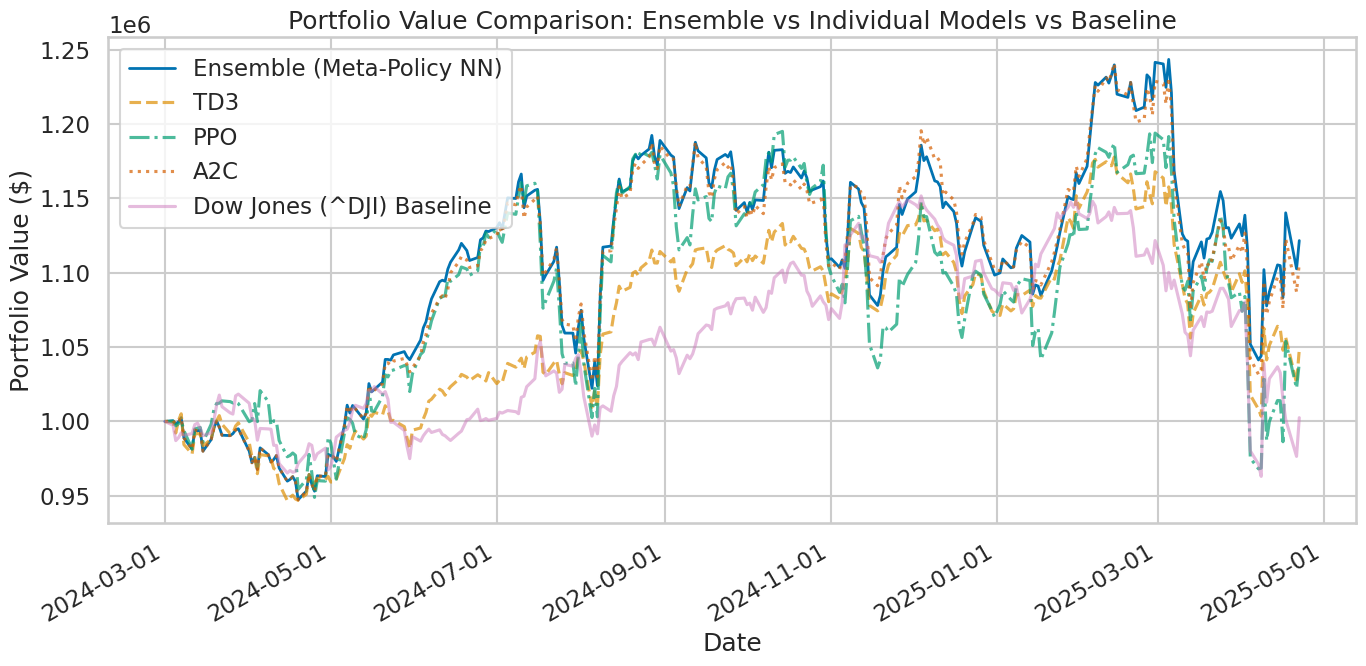

In [138]:
%matplotlib inline
plot_trading_results(
    moe_resuts,
    td3_results,
    ppo_results,
    a2c_results,
    dji,
    baseline_df
)

### Stacked RL (PPO Meta-Model)

#### StableBaselines PPO

In [44]:
from stable_baselines3.common.policies import ActorCriticPolicy
import torch.nn as nn

class SoftmaxGatingPolicy(ActorCriticPolicy):
    def _build(self, lr_schedule):
        # 1) Run the normal build so self.action_net is created
        super()._build(lr_schedule)

        # 2) Wrap the action head with a softmax
        #    so any “mean” the Gaussian sees is already on the simplex
        self.action_net = nn.Sequential(
            self.action_net,
            nn.Softmax(dim=-1)
        )


In [45]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class SoftGatingEnv(gym.Env):
    """
    Custom Environment for soft Mixture-of-Experts PPO.
    Action = weights over experts (continuous vector summing to 1).
    Executes weighted average of expert actions in the base environment.
    """
    metadata = {"render_modes": [], "render_fps": 4}

    def __init__(self, base_environment_creator, experts, experts_deterministic=True):
        super().__init__()

        self.base_env = base_environment_creator()
        self.experts = experts
        self.num_experts = len(experts)
        self.experts_deterministic = experts_deterministic

        # New action space: weights over experts
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(self.num_experts,), dtype=np.float32)

        self.observation_space = self.base_env.observation_space
        self._current_obs = None

        if hasattr(self.base_env, 'close'):
            self.base_env.close()
        self.base_env = base_environment_creator()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        observation, info = self.base_env.reset(seed=seed, options=options)
        self._current_obs = observation
        return observation, info

    def step(self, action):
        """
        Executes one step using a weighted average of expert actions.

        Args:
            action: A weight vector (length == num_experts) for soft selection.

        Returns:
            observation, reward, terminated, truncated, info
        """
        if not isinstance(action, np.ndarray) or action.shape != (self.num_experts,):
            raise ValueError(f"Invalid action shape {action.shape}. Expected shape ({self.num_experts},)")

        # Normalize weights if not already normalized (optional)
        weights = action 

        # Get actions from all experts
        expert_actions = []
        for expert in self.experts:
            act, _ = expert.predict(self._current_obs, deterministic=self.experts_deterministic)
            expert_actions.append(act)
        expert_actions = np.stack(expert_actions)  # shape: (num_experts, action_dim)

        # Weighted sum of actions
        final_action = np.sum(weights[:, None] * expert_actions, axis=0)

        observation, reward, terminated, truncated, info = self.base_env.step(final_action)
        self._current_obs = observation

        info['expert_weights'] = weights
        info['expert_actions'] = expert_actions
        info['final_action'] = final_action

        return observation, reward, terminated, truncated, info

    def render(self):
        pass  # Implement if needed

    def close(self):
        self.base_env.close()


In [141]:
class GatingEnv(gym.Env):
    """
    Custom Environment for training a PPO gating policy with Stable Baselines3.

    The action of this environment is the index of the expert policy to use.
    The step function executes the selected expert's action in the base environment.
    """
    metadata = {"render_modes": [], "render_fps": 4} # Basic metadata

    def __init__(self, base_environment_creator, experts, experts_deterministic=True):
        """
        Args:
            base_environment_creator: A function that returns an instance
                                      of your underlying Gym environment (e.g., lambda: gym.make("YourBaseEnv-v0")).
            experts: A list of pre-trained expert policy models (e.g., SB3 models).
            experts_deterministic: Whether to use deterministic actions from the experts. Recommended: True.
        """
        super().__init__()

        # Create an instance of the base environment to derive spaces
        self.base_env = base_environment_creator()
        self.experts = experts
        self.num_experts = len(experts)
        self.experts_deterministic = experts_deterministic

        # Action space for the Gating Policy: Choose an expert index
        self.action_space = spaces.Discrete(self.num_experts)

        # Observation space for the Gating Policy: Same as the base environment
        self.observation_space = self.base_env.observation_space

        # Internal state - current observation from the base environment
        self._current_obs = None
        # Ensure the base environment is closed if we created a temporary one
        if hasattr(self.base_env, 'close'):
             self.base_env.close()
        # Recreate for actual use
        self.base_env = base_environment_creator()


    def reset(self, seed=None, options=None):
        """Resets the underlying environment and returns the initial observation."""
        super().reset(seed=seed) # Important for seeding

        observation, info = self.base_env.reset(seed=seed, options=options)
        self._current_obs = observation
        # print(f"GatingEnv Reset: Obs shape {observation.shape}") # Debug
        return observation, info

    def step(self, action):
        """
        Executes one step in the environment.

        Args:
            action: The index of the expert policy chosen by the SB3 PPO agent.

        Returns:
            observation, reward, terminated, truncated, info
        """
        if not self.action_space.contains(action):
             raise ValueError(f"Invalid action '{action}'. It must be an integer from 0 to {self.num_experts - 1}.")

        # 1. Select the expert based on the action (expert index)
        chosen_expert = self.experts[action]

        # 2. Get the *base action* from the selected expert using the current observation
        base_action, _ = chosen_expert.predict(
            self._current_obs,
            deterministic=self.experts_deterministic
        )

        # 3. Execute the *base action* in the underlying environment
        observation, reward, terminated, truncated, info = self.base_env.step(base_action)

        # Store the new observation for the next step
        self._current_obs = observation

        # Add chosen expert info if desired (optional)
        info['chosen_expert_index'] = action
        info['base_action'] = base_action # Be careful if base_action is large

        # print(f"GatingEnv Step: Expert={action}, Reward={reward:.4f}, Term={terminated}, Trunc={truncated}") # Debug

        return observation, reward, terminated, truncated, info

    def render(self):
        """Renders the underlying environment."""
        # Depending on your base_env, you might need to implement this
        # return self.base_env.render()
        pass # Or implement if needed

    def close(self):
        """Closes the underlying environment."""
        self.base_env.close()

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv # Choose one

# --- Assume these are defined ---
# BASE_ENV_ID = "YourBaseEnv-v0" # Or your specific environment ID/class
# def create_base_env():
#     # Function to create an instance of your base environment
#     # This is needed if using SubprocVecEnv or complex env setup
#     env = gym.make(BASE_ENV_ID)
#     # Add any wrappers if needed
#     return env

# experts = [...] # Your list of loaded DDPG, PPO, A2C experts

# --- Training Setup ---

# Function to create the gating environment (needed for make_vec_env)
# def create_gating_env():
#     return GatingEnv(create_base_env, experts, experts_deterministic=True)

if __name__ == "__main__": # Important for SubprocVecEnv
    # It's recommended to use a VecEnv even for a single environment
    # n_envs = 1 # Or more if using SubprocVecEnv and resources allow
    # gating_vec_env = make_vec_env(create_gating_env, n_envs=n_envs, vec_env_cls=DummyVecEnv)
    # Or for parallel environments:
    # gating_vec_env = make_vec_env(create_gating_env, n_envs=4, vec_env_cls=SubprocVecEnv)

    # Or create a single instance directly (less standard for SB3 but works)
    # gating_env_single = SoftGatingEnv(
    #     base_environment_creator=lambda: CustomStockTradingEnv(df=train, **env_kwargs),
    #     experts=[trained_td3, trained_ppo, trained_a2c],
    #     experts_deterministic=True)

    gating_env_single = GatingEnv(
        base_environment_creator=lambda: CustomStockTradingEnv(df=train, **env_kwargs),
        experts=[trained_td3, trained_ppo, trained_a2c],
        experts_deterministic=True)
    # PPO Model - learns a policy for the GatingEnv (i.e., how to choose experts)
    # Use the same policy network type as your base env (e.g., "MlpPolicy")
    # Adjust hyperparameters as needed
    # gating_model = PPO(
    #     SoftmaxGatingPolicy,
    #     # "MlpPolicy",
        
    #     gating_env_single, # Use gating_vec_env if you created a VecEnv
    #     # verbose=1,
    #     n_steps=1024,      # Standard PPO hyperparameter
    #     batch_size=128,       # Standard PPO hyperparameter
    #     n_epochs=10,         # Standard PPO hyperparameter
    #     gamma=0.99,        # Discount factor (tune based on your task)
    #     gae_lambda=0.95,   # GAE parameter
    #     clip_range=0.2,    # PPO clipping range
    #     ent_coef=0.01,     # Entropy coefficient (tune for exploration)
    #     learning_rate=1e-4,# Learning rate
    #     tensorboard_log="./ppo_gating_tensorboard/" # Optional: for logging
    # )
    gating_model = PPO(
        # SoftmaxGatingPolicy,
        "MlpPolicy",
        
        gating_env_single, # Use gating_vec_env if you created a VecEnv
        # verbose=1,
        n_steps=1024,      # Standard PPO hyperparameter
        batch_size=128,       # Standard PPO hyperparameter
        n_epochs=10,         # Standard PPO hyperparameter
        gamma=0.99,        # Discount factor (tune based on your task)
        gae_lambda=0.95,   # GAE parameter
        clip_range=0.2,    # PPO clipping range
        ent_coef=0.01,     # Entropy coefficient (tune for exploration)
        learning_rate=1e-6,# Learning rate
        tensorboard_log="./ppo_gating_tensorboard/" # Optional: for logging
    )

    print("Starting training of the PPO Gating Policy...")
    # Train the PPO model on the GatingEnv
    # Adjust total_timesteps based on how long you need to train
    gating_model.learn(total_timesteps=60000, progress_bar=True) # Example: 100k steps

    # Save the trained gating policy
    gating_model.save("ppo_moe_gating_sb3")
    print("Training finished and gating policy saved.")

    # Clean up the environment
    # if n_envs > 0:
    #     gating_vec_env.close()
    # else:
    gating_env_single.close()



In [69]:
# # --- How to use the trained gating policy later ---
# loaded_gating_model = PPO.load("ppo_moe_gating_sb3")
# base_env = CustomStockTradingEnv(df=train, **env_kwargs)
# experts = [trained_ddpg, trained_ppo, trained_a2c]
# obs, _ = base_env.reset()
# done = False
# while not done:
#     # 1. Gating model predicts which expert to use
#     weights, _ = loaded_gating_model.predict(obs, deterministic=True)
#     print(weights)
    
#     # 2. Select the expert
#     actions = []
#     for expert in experts:
#         action, _ = expert.predict(obs, deterministic=True)
#         actions.append(action)
    
#     # 3. Expert predicts the base action
#     base_action = np.sum(weights[:, None] * np.array(actions), axis=0)
#     # 4. Step the base environment
#     obs, reward, terminated, truncated, info = base_env.step(base_action)
#     done = terminated or truncated
#     # ... log results ...
#     # print(expert_index)
# base_env.close()

In [46]:

def DRL_prediction_MoE_selection(gating_model, experts, environment, deterministic=True): # Added MoE specifics
    """Make a prediction using the MoE gating policy"""
    test_env, test_obs = environment.get_sb_env() # Get SB3 compatible env and initial obs

    account_memory = None
    actions_memory = None
    state_memory = None
    rewards_memory = []
    # Optional: Track expert choices during the run
    # expert_indices_memory = []

    test_env.reset() # Reset the environment instance
    max_steps = len(environment.df.index.unique()) - 1

    for i in range(len(environment.df.index.unique())):
        # --- MoE Inference Steps ---
        # 1. Gating model predicts which expert to use
        # weights, _ = gating_model.predict(test_obs, deterministic=deterministic)
        # weights = weights.reshape(-1)
        expert_index, _ = gating_model.predict(test_obs, deterministic=deterministic)
        # print(weights.shape)
        # expert_indices_memory.append(expert_index) # Optional tracking
        # print(f"Expert Index: {expert_index}") # Debug
        # 2. Select the expert
        if 0 <= expert_index[0] < len(experts):
            chosen_expert = experts[expert_index[0]]
        else:
            # Handle potential invalid index if needed (e.g., default or raise error)
            print(f"Warning: Invalid expert index {expert_index} in DRL_prediction_MoE. Defaulting to 0.")
            chosen_expert = experts[0]

        # 3. Chosen expert predicts the base action
        action, _states = chosen_expert.predict(test_obs, deterministic=deterministic)
        
        # actions = []
        # for expert in experts:
        #     action, _ = expert.predict(test_obs, deterministic=deterministic)
        #     actions.append(action.reshape(-1))
        
        # # 4. Weighted sum of actions
        # actions = np.stack(actions) 
        # action = np.sum(weights[:, np.newaxis] * actions, axis=0).reshape(1,-1)
        # print(action.shape)
        # print(action)
        # print("weights", weights)
        # print("actions", actions)
        # print(action)
        # break
        # --- End MoE Inference Steps ---

        # --- Original function logic continues ---
        next_obs, rewards, dones, info = test_env.step(action) # Step using the expert's action
        rewards_memory.append(rewards)
        test_obs = next_obs

        # Saving memory logic (only at the end)
        if (i == max_steps - 1):
            account_memory = test_env.env_method(method_name="save_asset_memory")
            actions_memory = test_env.env_method(method_name="save_action_memory")
            state_memory = test_env.env_method(method_name="save_state_memory")

        if dones[0]:
            print("hit end!")
            # Ensure memory is saved if episode ends early before max_steps-1
            if account_memory is None: # Check if memory hasn't been saved yet
                 account_memory = test_env.env_method(method_name="save_asset_memory")
                 actions_memory = test_env.env_method(method_name="save_action_memory")
                 state_memory = test_env.env_method(method_name="save_state_memory")
            break

    # Make sure account_memory is fetched if loop finishes without hitting dones[0] early
    # This check might be redundant if the loop guarantees i == max_steps - 1 is reached
    # unless dones[0] is True exactly on the last step.
    if account_memory is None:
         account_memory = test_env.env_method(method_name="save_asset_memory")
         actions_memory = test_env.env_method(method_name="save_action_memory")
         state_memory = test_env.env_method(method_name="save_state_memory")


    # Return results (consider adding expert_indices_memory if needed)
    return account_memory[0], actions_memory[0], state_memory[0], np.array(rewards_memory) #, expert_indices_memory

In [144]:
gating_account_value, gating_actions, gating_states_df, gating_rewards = DRL_prediction_MoE_selection(
    gating_model, [trained_td3, trained_ppo, trained_a2c],
    CustomStockTradingEnv(df=trade, **env_kwargs)
)

hit end!


In [145]:
gating_account_value.tail()

,date,account_value
281,2025-04-15,1.103386e+06
282,2025-04-16,1.082465e+06
283,2025-04-17,1.149860e+06
284,2025-04-21,1.112736e+06
285,2025-04-22,1.130878e+06


In [146]:
backtest_stats(gating_account_value)

Annual return          0.114463
Cumulative returns     0.130878
Annual volatility      0.225649
Sharpe ratio           0.594357
Calmar ratio           0.684597
Stability              0.408919
Max drawdown          -0.167197
Omega ratio            1.112754
Sortino ratio          0.863650
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.936531
Daily value at risk   -0.027897
dtype: float64


Annual return          0.114463
Cumulative returns     0.130878
Annual volatility      0.225649
Sharpe ratio           0.594357
Calmar ratio           0.684597
Stability              0.408919
Max drawdown          -0.167197
Omega ratio            1.112754
Sortino ratio          0.863650
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.936531
Daily value at risk   -0.027897
dtype: float64

In [147]:
gating_results = pd.DataFrame(gating_account_value, columns=["date", "account_value"])

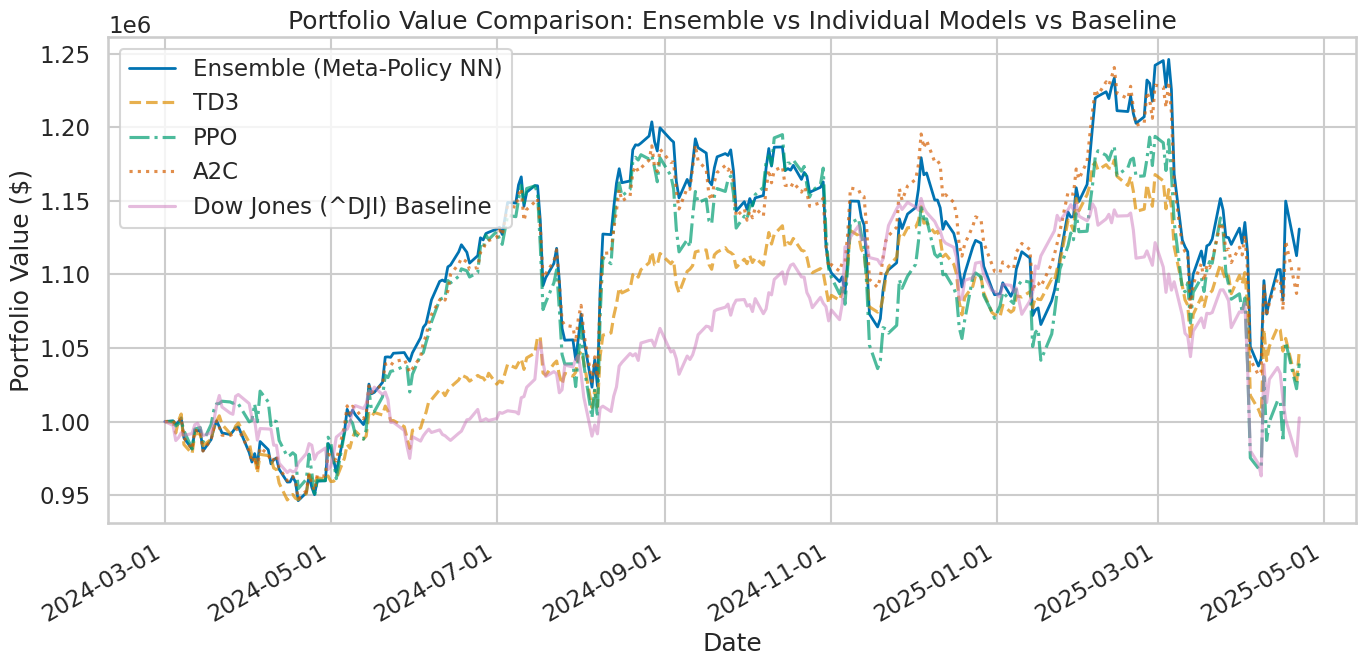

In [148]:
plot_trading_results(
    gating_results,
    td3_results,
    ppo_results,
    a2c_results,
    dji,
    baseline_df
)

### Benchmarking

In [149]:
df_snp = YahooDownloader(
    start_date=TEST_START_DATE, end_date=TEST_END_DATE, ticker_list=["^GSPC"]
).fetch_data()
df_snp = df_snp[["date", "close"]]
fst_day = df_snp["close"][0]
snp = pd.merge(
    df_snp["date"],
    df_snp["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
)
baseline_df_snp = get_baseline(
    ticker="^GSPC",
    start=TEST_START_DATE,
    end=TEST_END_DATE,
)
baseline_stats = backtest_stats(baseline_df_snp, value_col_name='close')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (286, 8)
Shape of DataFrame:  (286, 8)
Annual return          0.025800
Cumulative returns     0.029332
Annual volatility      0.185300
Sharpe ratio           0.229749
Calmar ratio           0.136493
Stability              0.483404
Max drawdown          -0.189022
Omega ratio            1.046451
Sortino ratio          0.326733
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.713002
Daily value at risk   -0.023177
dtype: float64


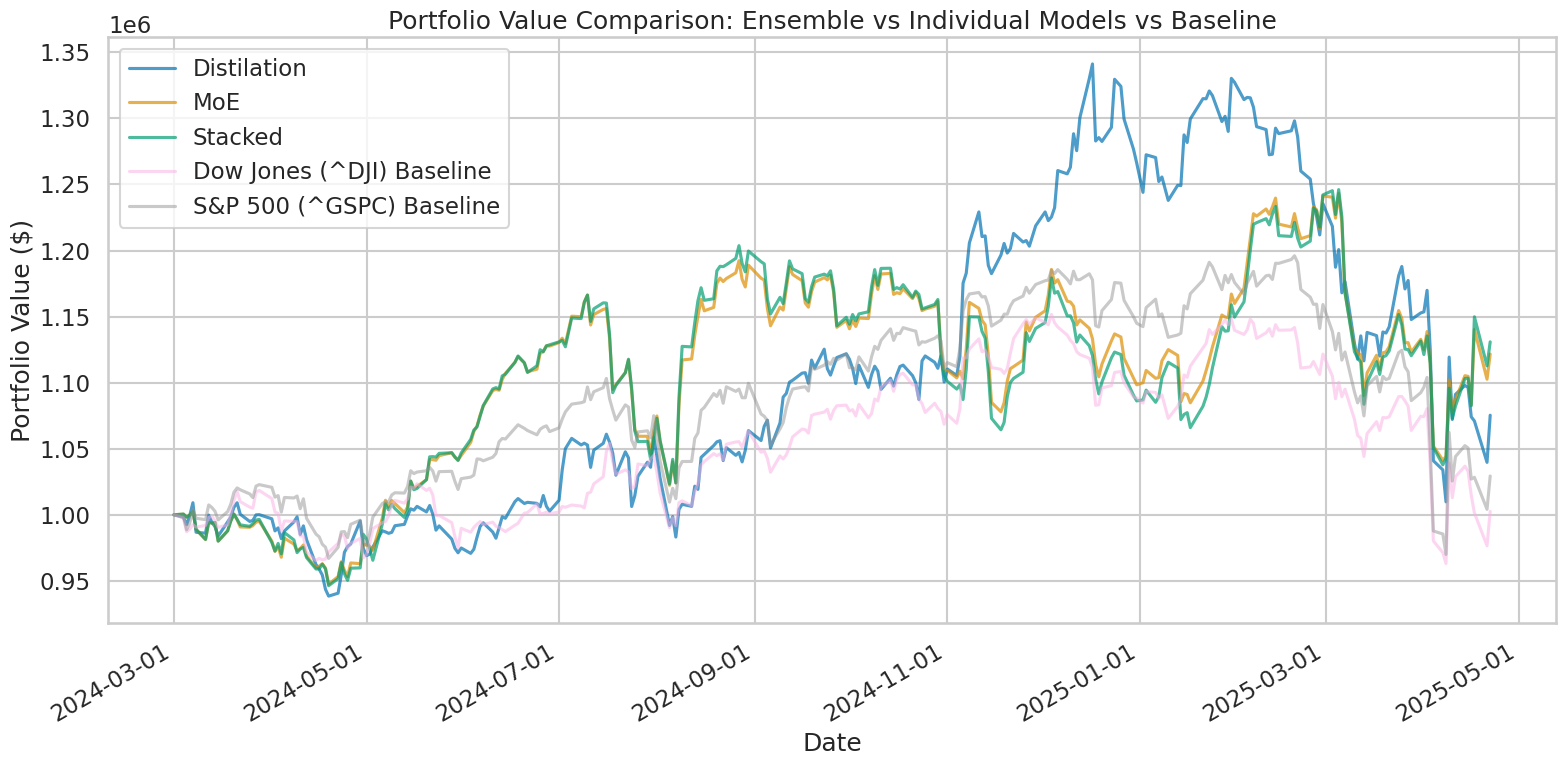

In [150]:
%matplotlib inline
sns.set_theme(style='whitegrid', context='talk')

# Optionally, define a Seaborn color palette
palette = sns.color_palette("colorblind", 8)

# Convert 'date' columns to datetime if they are not already
# ensemble_results['date'] = pd.to_datetime(ensemble_results['date'])
student_results['date'] = pd.to_datetime(student_results['date'])
moe_resuts['date'] = pd.to_datetime(moe_resuts['date'])
gating_results['date'] = pd.to_datetime(gating_results['date'])
td3_results['date'] = pd.to_datetime(td3_results['date'])
# ddpg_results['date'] = pd.to_datetime(ddpg_results['date'])
ppo_results['date'] = pd.to_datetime(ppo_results['date'])
a2c_results['date'] = pd.to_datetime(a2c_results['date'])
dji['date'] = pd.to_datetime(baseline_df['date'])
snp['date'] = pd.to_datetime(baseline_df_snp['date'])

# Create the figure
plt.figure(figsize=(16, 8))

# Plot each series using Seaborn's palette for consistency
plt.plot(student_results['date'], student_results['account_value'], 
        label='Distilation', linestyle='-', alpha=0.7, color=palette[0])

plt.plot(moe_resuts['date'], moe_resuts['account_value'],
        label='MoE', linestyle='-', alpha=0.7, color=palette[1])

plt.plot(gating_results['date'], gating_results['account_value'],
        label='Stacked', linestyle='-', alpha=0.7, color=palette[2])

# plt.plot(td3_results['date'],td3_results['account_value'], 
#         label='TD3', linestyle='--', alpha=0.7, color=palette[3])
# plt.plot(ppo_results['date'], ppo_results['account_value'], 
#         label='PPO', linestyle='-.', alpha=0.7, color=palette[4])
# plt.plot(a2c_results['date'], a2c_results['account_value'], 
#         label='A2C', linestyle=':', alpha=0.7, color=palette[5])
plt.plot(dji['date'], dji['close'], 
        label='Dow Jones (^DJI) Baseline', linestyle='-', alpha=0.5, color=palette[6])

plt.plot(snp['date'], snp['close'],
        label='S&P 500 (^GSPC) Baseline', linestyle='-', alpha=0.5, color=palette[7])


# Format the x-axis for dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

# Add titles and labels
plt.title('Portfolio Value Comparison: Ensemble vs Individual Models vs Baseline')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

### Save Models

In [151]:
gating_model.save("gating_model.zip")

In [153]:
torch.save(student_policy.model.state_dict(), "student_model.pth")

In [152]:
torch.save(moe_policy.gating_net.state_dict(), "moe_gating_net.pth")

### Inference

In [47]:
df['tic'].unique()

array(['AAPL', 'ABBV', 'ACN', 'ADBE', 'AMZN', 'AVGO', 'BAC', 'COST',
       'CRM', 'CVX', 'GOOG', 'HD', 'KO', 'LLY', 'MA', 'META', 'MSFT',
       'NVDA', 'ORCL', 'PEP', 'PG', 'TMO', 'TSLA', 'UNH', 'V', 'WMT',
       'XOM'], dtype=object)

In [48]:
TEST_START_DATE = "2024-03-01"
TEST_END_DATE = END_DATE

trade = data_split(df, TEST_START_DATE,TEST_END_DATE)

In [49]:
student_model = StudentPolicy(state_dim, action_dim)
student_model.load_state_dict(torch.load("student_model.pth"))

<All keys matched successfully>

In [50]:
moe_model = GatingNetwork(input_dim=states_tensor.shape[1], num_experts=3)
moe_model.load_state_dict(torch.load("moe_gating_net.pth"))

<All keys matched successfully>

In [51]:
from stable_baselines3 import PPO
stacked_model = PPO.load("gating_model.zip")

/home/nyuad/miniconda3/envs/finRl/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [52]:
# moe_policy = MoEPolicyWrapper(moe_model, [trained_td3, trained_ppo, trained_a2c], device)
moe_policy = MoEPolicyWrapper(moe_model, [trained_td3, trained_ppo, trained_a2c], device)


moe_account_value, moe_actions, moe_states_df, moe_rewards = student_prediction(
    moe_policy, CustomStockTradingEnv(df=trade, **env_kwargs)
)

In [53]:
gating_account_value, gating_actions, gating_states_df, gating_rewards = DRL_prediction_MoE_selection(
    stacked_model, [trained_td3, trained_ppo, trained_a2c],
    CustomStockTradingEnv(df=trade, **env_kwargs)
)

hit end!


In [54]:
student_policy = StudentPolicyWrapper(student_model.to(device), device)

student_account_value, student_actions, student_states_df, student_rewards = student_prediction(
    student_policy, CustomStockTradingEnv(df=trade, **env_kwargs)
)

In [191]:
student_account_value

,date,account_value
0,2024-03-01,1.000000e+06
1,2024-03-04,9.979996e+05
2,2024-03-05,9.925407e+05
3,2024-03-06,9.994667e+05
4,2024-03-07,1.009113e+06
...,...,...
281,2025-04-15,1.096402e+06
282,2025-04-16,1.074124e+06
283,2025-04-17,1.070991e+06
284,2025-04-21,1.039664e+06


In [175]:
df['date'].max()

'2025-04-22'

In [200]:
other_account_value = dji.copy()
other_account_value.rename(columns={"close": "account_value"}, inplace=True)
other_account_value

,date,account_value
0,2024-03-01,1.000000e+06
1,2024-03-04,9.975043e+05
2,2024-03-05,9.871522e+05
3,2024-03-06,9.890929e+05
4,2024-03-07,9.924265e+05
...,...,...
281,2025-04-15,1.032788e+06
282,2025-04-16,1.014890e+06
283,2025-04-17,1.001403e+06
284,2025-04-21,9.765405e+05


In [56]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

# 1. CHOOSE YOUR RENDERER
pio.renderers.default = "browser"

# 2. LOAD & PREPARE YOUR DATA
df = gating_account_value.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

df['Open']  = baseline_df['open']
df['High']  = baseline_df['high']
df['Low']   = baseline_df['low']
df['Close'] = baseline_df['close']

# 3. BUILD THE FRAMES (each frame shows 1 candle + line chart)
frames = []

for k in range(1, len(df) + 1):
    slice_ = df.iloc[:k]

    candles = go.Candlestick(
        x=slice_['date'],
        open=slice_['Open'],
        high=slice_['High'],
        low=slice_['Low'],
        close=slice_['Close'],
        increasing_line_color='green',
        decreasing_line_color='red',
        increasing_line_width=6,  # <-- wider candles
        decreasing_line_width=6,
        showlegend=False,
        yaxis='y2'
    )

    account_trace = go.Scatter(
        x=slice_['date'],
        y=slice_['account_value'],
        mode='lines',
        name='Account Value',
        line=dict(width=2, color='cyan')
    )

    val = slice_['account_value'].iloc[-1]
    date_str = slice_['date'].iloc[-1].strftime('%Y-%m-%d')
    annot = go.layout.Annotation(
        text=f"Date: {date_str}<br>Account Value: ${val:,.2f}",
        x=0.02, y=0.98,
        xref='paper', yref='paper',
        showarrow=False,
        font=dict(color='white', size=18),
        bgcolor="rgba(0,0,0,0.5)"
    )

    frames.append(go.Frame(data=[candles, account_trace], name=str(k), layout=go.Layout(annotations=[annot])))

# 4. INITIAL FIGURE
fig = go.Figure(frames=frames)

# Add initial traces
fig.add_trace(go.Candlestick(
    x=df['date'].iloc[:1],
    open=df['Open'].iloc[:1],
    high=df['High'].iloc[:1],
    low=df['Low'].iloc[:1],
    close=df['Close'].iloc[:1],
    increasing_line_color='green',
    decreasing_line_color='red',
    increasing_line_width=6,
    decreasing_line_width=6,
    showlegend=False,
    yaxis='y2'
))

fig.add_trace(go.Scatter(
    x=df['date'].iloc[:1],
    y=df['account_value'].iloc[:1],
    mode='lines',
    name='Account Value',
    line=dict(width=2, color='cyan')
))

# Initial annotation
init_date = df['date'].iloc[0].strftime('%Y-%m-%d')
init_val  = df['account_value'].iloc[0]
fig.add_annotation(
    text=f"Date: {init_date}<br>Account Value: ${init_val:,.2f}",
    x=0.02, y=0.98,
    xref='paper', yref='paper',
    showarrow=False,
    font=dict(color='white', size=18),
    bgcolor="rgba(0,0,0,0.5)",
)

# 5. ANIMATION + LAYOUT
anim_args = {
    "frame": {"duration": 2000, "redraw": True},
    "fromcurrent": True,
    "transition": {"duration": 100}
}

fig.update_layout(
    font=dict(color="white", size=18),
    template="plotly_dark",
    paper_bgcolor="black",
    plot_bgcolor="black",
    autosize=True,
    margin=dict(l=0, r=0, t=40, b=0),
    title="Account Value + Candlestick Chart (Wider Candles)",
    title_x=0.5,

    # Axes Config
    xaxis=dict(
        showgrid=False,
        range=[df['date'].min(), df['date'].max()]
    ),
    yaxis=dict(
        title='Account Value',
        showgrid=False,
        range=[
            df['account_value'].min() * 0.98,
            df['account_value'].max() * 1.02
        ]
    ),
    yaxis2=dict(
        title='Price',
        overlaying='y',
        side='right',
        showgrid=False,
        range=[
            df['Low'].min() * 0.98,
            df['High'].max() * 1.02
        ]
    ),

    xaxis_rangeslider_visible=False,

    # Animation controls
    updatemenus=[{
        "buttons": [
            {"args": [None, anim_args], "label": "Play",  "method": "animate"},
            {"args": [[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}],
             "label": "Pause", "method": "animate"}
        ],
        "type": "buttons", "showactive": False,
        "x": 0.1, "y": 0, "pad": {"t": 60}
    }],
    sliders=[{
        "active": 0,
        "currentvalue": {"prefix": "Frame: ", "visible": True},
        "pad": {"b": 10, "t": 50},
        "len": 0.9, "x": 0.05, "y": 0,
        "steps": [
            {"args": [[f.name], anim_args], "label": f.name, "method": "animate"}
            for f in frames
        ]
    }]
)

# 6. SHOW FULL-SCREEN & RESPONSIVE
fig.show(config={"responsive": True, "displayModeBar": True})
pio.write_html(fig, file='chart.html', auto_open=False, full_html=True, include_plotlyjs='cdn')

In [55]:
gating_account_value.to_csv('data/gating_account_value.csv', index=False)
baseline_df.to_csv('data/baseline_df.csv', index=False)
student_account_value.to_csv('data/student_account_value.csv', index=False)
moe_account_value.to_csv('data/moe_account_value.csv', index=False)
